# Libraries

In [7]:
# IO
import os
import csv
import pathlib
from pathlib import Path
import chardet
import warnings

# Utilities
import numpy as np 
import pandas as pd
import copy

# Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from torchtext.vocab import Vocab
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling and training
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
## Metrics
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore", category=FutureWarning)


Download `nltk` resources (only needs to run once per machine)

In [6]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/exterior/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/exterior/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Classes

Early stopping class (pytorch does not have a built in early stopping callback)

In [ ]:
class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=1, restore_best_weights=True, mode='min'):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.mode = mode  # 'min' for loss, 'max' for accuracy, etc.
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        # Determine if the current score is better
        if self.best_score is None:
            self.best_score = current_score
            if self.restore_best_weights:
                self.best_model_state = copy.deepcopy(model.state_dict())
        elif (self.mode == 'min' and current_score < self.best_score) or \
             (self.mode == 'max' and current_score > self.best_score):
            self.best_score = current_score
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore(self, model):
        if self.restore_best_weights and self.best_model_state:
            model.load_state_dict(self.best_model_state)

## Models

In [ ]:
class LoSiento(nn.Module):
    def __init__(self, max_features, embed_dim=128, lstm_out=196, output_classes=3):
        super(LoSiento, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=max_features, embedding_dim=embed_dim)
        self.spatial_dropout = nn.Dropout2d(p=0.5)  # Approximate SpatialDropout1D
        self.lstm = nn.LSTM(embed_dim, lstm_out, batch_first=True, dropout=0.3)
        
        self.dropout_1 = nn.Dropout(p=0.2)
        self.dense_1 = nn.Linear(lstm_out, 100)
        self.dropout_2 = nn.Dropout(p=0.4)
        self.output_layer = nn.Linear(100, output_classes)

    def forward(self, x):
        x = self.embedding(x)                      # (batch, seq_len, embed_dim)
        x = x.permute(0, 2, 1)                     # For Dropout2d: (batch, embed_dim, seq_len)
        x = self.spatial_dropout(x)
        x = x.permute(0, 2, 1)                     # Back to (batch, seq_len, embed_dim)
        
        x, _ = self.lstm(x)                        # LSTM returns (output, (h_n, c_n))
        x = x[:, -1, :]                            # Get the output from the last timestep
        
        x = self.dropout_1(x)
        x = F.relu(self.dense_1(x))
        x = self.dropout_2(x)
        x = self.output_layer(x)
        return F.softmax(x, dim=1)         

# Functions

The encoding of the text file is automatically detected here with some confidence. It could be extracted from terminal using
```
file -I file.txt
```

Terminal method (not os agnostic):

In [5]:
!file -I ~/Documents/IML/Project/Part2/_data/FinancialPhraseBank-v1.0/Sentences_50Agree.txt

/Users/exterior/Documents/IML/Project/Part2/_data/FinancialPhraseBank-v1.0/Sentences_50Agree.txt: text/plain; charset=iso-8859-1


Python method:

In [2]:
def extract_sentences_from_file(filepath):
    """Given an input txt file, extract sentences 
    and associated sentiments

    Args:
        filepath (string): path to string 

    Returns:
        list: list of sentences and sentiments
    """
    sentences = []
    # automatically detect endoding (best guess)
    with open(filepath, 'rb') as file:
        encoding = chardet.detect(file.read())['encoding']
    # read and split
    with open(filepath, 'r', encoding=encoding) as file:
        for line in file:
            line = line.strip()
            if '.@' in line:
                sentence, sentiment = line.rsplit('.@', 1)
                sentence = sentence.strip()
                sentiment = sentiment.strip().lower()
                sentence = fix_common_mojibake(sentence)
                sentences.append((sentence, sentiment))
    return sentences

In [3]:
def txt_to_csv(txt_path, output_csv):
    """Takes a file path as input and generates a .csv file
    which contains sentences and sentiments as columns, extracted
    from the .txt file corresponding to the path

    Args:
        txt_path (string): path to the .txt file
        output_csv (string): path to desired output .csv file
    """
    # Skip processing if CSV already exists
    if os.path.exists(output_csv):
        print(f"{output_csv} already exists. Skipping processing.")
        return

    sentences = extract_sentences_from_file(txt_path)

    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Sentence', 'Sentiment'])  # Header
        writer.writerows(sentences)
    print(f"Processed files and wrote output to {output_csv}")


This function is needed as the text files seem to be corrupted, for example one sentence is:
```
Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004
```
The characters `+ñ` are a result of choosing the wrong encoding; in fact, here the detected encoding is latin-1, and those correspond to `ä` in utf-8. The function below is used to fix these common mistakes

In [4]:
 def fix_common_mojibake(text):
    """Function to manually handle encoding errors

    Args:
        text (string): input sentence

    Returns:
        string: output corrected sentence
    """
    replacements = {
        '+ñ': 'ä',
        '+í': 'é',
        '+ô': 'ö',
        '+ü': 'ü'
        }
    for wrong, right in replacements.items():
        text = text.replace(wrong, right)
    return text

In [5]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

We need to be careful when splitting the data into training and test sets. We would like the test set to be drawn from the file with 100% sentiment agreement in a stratified manner, but at the same time we need to make sure that none of the elements from the test set appears in the training/validation sets.

In [6]:
def create_df():
    """Import data and creates csv's and pandas dataframes

    Returns:
        pandas dataframes for training and testing
    """
    print("Please select which training set to use. Training data is split based on the percentage of agreement in the sentiment estimator.")
    print("Options:")
    print("(1) 50")
    print("(2) 66")
    print("(3) 75")
    print("(4) 100")
    percentage = input()
    if percentage=='50':
        txt_path = RAW_DATA_FOLDER + 'Sentences_50Agree.txt'
        csv_path = DATASET_FOLDER + 'sentences_50.csv'
        txt_to_csv(txt_path, csv_path)
    elif percentage=='66':
        txt_path = RAW_DATA_FOLDER + 'Sentences_66Agree.txt'
        csv_path = DATASET_FOLDER + 'sentences_66.csv'
        txt_to_csv(txt_path, csv_path)
    elif percentage=='75':
        txt_path = RAW_DATA_FOLDER + 'Sentences_75Agree.txt'
        csv_path = DATASET_FOLDER + 'sentences_75.csv'
        txt_to_csv(txt_path, csv_path)
    elif percentage=='100':
        txt_path = RAW_DATA_FOLDER + 'Sentences_AllAgree.txt'
        csv_path = DATASET_FOLDER + 'sentences_100.csv'
        txt_to_csv(txt_path, csv_path)
    else:
        print("The percentage provided is not admitted, skipping.")
        return

    txt_path_100 = RAW_DATA_FOLDER + 'Sentences_AllAgree.txt'
    csv_path_100 = DATASET_FOLDER + 'sentences_100.csv'
    txt_to_csv(txt_path_100, csv_path_100)

    df_full = pd.read_csv(csv_path)
    df_100 = pd.read_csv(csv_path_100)

    test_df, _ = train_test_split(df_100, test_size=0.8, stratify=df_full['Sentiment'], random_state=42)

    df_train = df_full[~df_full['Sentence'].isin(test_df['Sentence'])].copy()

    return df_train, test_df

In [ ]:
def load_data(df, df_test, max_features=4000):
    """Load data into a format ready to be fed into training and testing

    Args:
        df (pandas dataframe): training dataframe
        df_test (pandas dataframe): testing dataframe
        max_features (int, optional): Defaults to 4000.

    Returns:
        Training and testing data + encoder for labels
    """
    le = LabelEncoder()

    # -----------------------------
    # TRAINING SET
    # -----------------------------
    tokenized_train = [sentence.lower().split() for sentence in df['Sentence'].values]
    counter = Counter(word for sent in tokenized_train for word in sent)
    vocab = Vocab(counter, max_size=max_features, specials=['<pad>', '<unk>'])

    indexed_train = [[vocab.stoi.get(word, vocab.stoi['<unk>']) for word in sentence] for sentence in tokenized_train]
    tensor_train = [torch.tensor(seq, dtype=torch.long) for seq in indexed_train]
    X_train = pad_sequence(tensor_train, batch_first=True, padding_value=vocab.stoi['<pad>'])

    le.fit(df['Sentiment'].values)
    y_train = torch.tensor(le.transform(df['Sentiment'].values), dtype=torch.long)

    # -----------------------------
    # TEST SET
    # -----------------------------
    tokenized_test = [sentence.lower().split() for sentence in df_test['Sentence'].values]
    indexed_test = [[vocab.stoi.get(word, vocab.stoi['<unk>']) for word in sentence] for sentence in tokenized_test]
    tensor_test = [torch.tensor(seq, dtype=torch.long) for seq in indexed_test]
    X_test = pad_sequence(tensor_test, batch_first=True, padding_value=vocab.stoi['<pad>'])

    y_test = torch.tensor(le.transform(df_test['Sentiment'].values), dtype=torch.long)

    return X_train, y_train, X_test, y_test, vocab, le

## Training function

In [ ]:
def train_model(model_choice,X,y):
    fold = 1
    accuracies = []

    for train_index, val_index in rskf.split(X, y):
        print(f"\n🔁 Fold {fold} -------------------------------")
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Re-initialize the model for each fold
        model = model_choice(max_features=4000, embed_dim=128, lstm_out=196, output_classes=3)
        model.build(input_shape=(None, X.shape[1]))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

        # Train
        model.fit(
            X_train, y_train,
            epochs=6,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0  # Set to 1 if you want detailed output
        )

        # Evaluate
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        accuracies.append(accuracy)
        print(f"✅ Fold {fold} Accuracy: {accuracy:.4f}")

        fold += 1


## Import data

OS-agnostic working folder and data folder definition

In [8]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
RAW_DATA_FOLDER = os.path.join(str(DATASET_FOLDER), "FinancialPhraseBank-v1.0","")

In [9]:
data_csv_path = DATASET_FOLDER+'data.csv'

Import data into pandas dataframe

In [11]:
df_train, df_test = create_df()

Please select which training set to use. Training data is split based on the percentage of agreement in the sentiment estimator.
Options:
(1) 50
(2) 66
(3) 75
(4) 100
/Users/exterior/Documents/IML/Project/Part2/_data/sentences_50.csv already exists. Skipping processing.
/Users/exterior/Documents/IML/Project/Part2/_data/sentences_100.csv already exists. Skipping processing.


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441 entries, 1594 to 1337
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   441 non-null    object
 1   Sentiment  441 non-null    object
dtypes: object(2)
memory usage: 10.3+ KB


In [13]:
df_train['Sentence'].isin(df_test['Sentence']).value_counts()

Sentence
False    4285
Name: count, dtype: int64

Perform text preprocessing

In [14]:
df_train['Sentence'] = df_train['Sentence'].apply(preprocess_text)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4285 entries, 0 to 4729
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   4285 non-null   object
 1   Sentiment  4285 non-null   object
dtypes: object(2)
memory usage: 100.4+ KB


In [18]:
max_fatures = 4000
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(df_train['Sentence'].values)

# train sets
X = tokenizer.texts_to_sequences(df_train['Sentence'].values)
X = pad_sequences(X)
Y = df_train['Sentiment']
le = LabelEncoder()
le.fit(Y.values)
y = le.transform(Y)

# test sets
X_test = tokenizer.texts_to_sequences(df_test['Sentence'].values)
X_test = pad_sequences(X_test)
Y_test = df_test['Sentiment']
y_test = le.transform(Y_test)


In [73]:
le.inverse_transform(y)

array(['neutral', 'neutral', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

## Visualizations

There is some class imbalance --> Stratified split is needed

<Axes: xlabel='count', ylabel='Sentiment'>

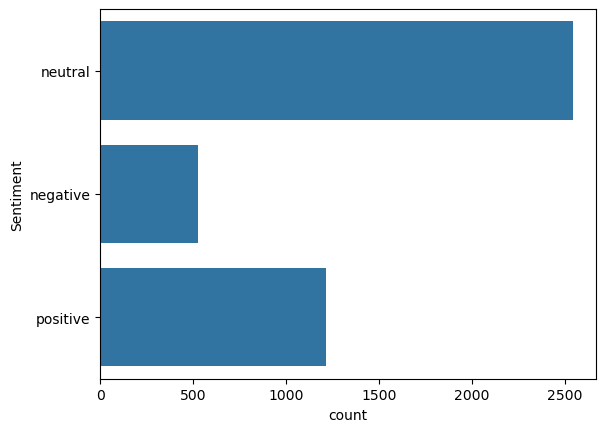

In [15]:
sns.countplot(df_train.Sentiment)

Check whether stratified split worked

<Axes: xlabel='count', ylabel='Sentiment'>

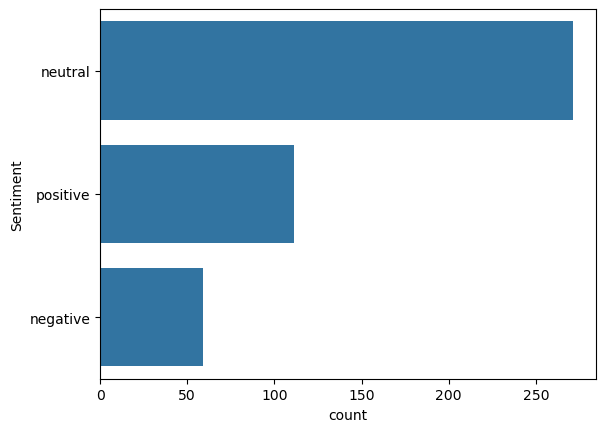

In [16]:
sns.countplot(df_test.Sentiment)

## Training

### Initialize model

In [28]:
model = LoSiento(max_features=4000, embed_dim=128, lstm_out=196, output_classes=3)

# Build the model (adjust input shape to your actual input length)
model.build(input_shape=(None, X_train.shape[1]))

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### Define early stopping policy

In [29]:
early_stop = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=1,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)

### Define cross-validator

In [32]:
n_splits = 5  # Number of folds
n_repeats = 3  # Number of repeats
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

### Start training

In [30]:
Model = model.fit(
    X_train, y_train,
    epochs=6,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/6


121/121 [==============================] - 12s 91ms/step - loss: 0.8990 - accuracy: 0.6014 - val_loss: 0.8210 - val_accuracy: 0.6294
Epoch 2/6
121/121 [==============================] - 11s 92ms/step - loss: 0.7309 - accuracy: 0.6834 - val_loss: 0.7420 - val_accuracy: 0.6620
Epoch 3/6
121/121 [==============================] - 11s 92ms/step - loss: 0.5552 - accuracy: 0.7726 - val_loss: 0.7125 - val_accuracy: 0.7086
Epoch 4/6
121/121 [==============================] - 11s 91ms/step - loss: 0.4129 - accuracy: 0.8447 - val_loss: 0.7844 - val_accuracy: 0.7203


In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {score[1]:.2f}")

Test accuracy: 0.77


In [23]:
sample = 'Technobrat company is the worst place in the world'
sample = [preprocess_text(sample)]
sample = tokenizer.texts_to_sequences(sample)
sample = pad_sequences(sample, dtype='int32', value=0)
print(sample)
sentiment = model.predict(sample,batch_size=1,verbose = 2)[0]
print(sentiment)
sentiment_index = np.argmax(sentiment)
le.inverse_transform([sentiment_index])


[[  2 382 181]]
1/1 - 0s - 114ms/epoch - 114ms/step
[0.0086253  0.9231022  0.06827253]


array(['neutral'], dtype=object)